In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *

/home/burbank/miniconda3/envs/fastai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| hide
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Twt_kg_m3":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Twt_kg_m3,Env
0,15,0.122736,7_2018
1,19,-0.982788,8_2018
2,16,-0.715674,4_2019
3,1,-0.604091,2_2019
4,4,0.138607,7_2018


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

weather_data

,Env,Year,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0_2018,2018,0.000254,0.319551,0.035621,0.227980,0.341458,0.546306,0.992078,0.527062,...,0.267738,0.596514,0.948693,0.767477,0.784856,0.121439,0.053526,0.972353,0.667356,0.210994
1,1_2019,2019,0.692550,0.167253,0.891801,0.174253,0.466269,0.819173,0.543367,0.116657,...,0.441986,0.123692,0.831439,0.161838,0.932493,0.240424,0.389518,0.758521,0.820345,0.818243
2,2_2019,2019,0.310805,0.834717,0.174031,0.880392,0.304212,0.506488,0.719241,0.154603,...,0.323938,0.086857,0.561431,0.251565,0.984370,0.421870,0.581498,0.474244,0.981454,0.242238
3,3_2018,2018,0.168983,0.146432,0.297660,0.404348,0.223658,0.995731,0.138922,0.520578,...,0.031069,0.861631,0.732336,0.925542,0.883066,0.972881,0.971857,0.554228,0.460823,0.003826
4,4_2019,2019,0.889311,0.760565,0.627111,0.917845,0.114576,0.790566,0.717116,0.168854,...,0.678892,0.392014,0.963459,0.935532,0.951570,0.240657,0.034179,0.424162,0.973886,0.850691
5,5_2019,2019,0.840537,0.551299,0.358102,0.831560,0.918915,0.831252,0.282564,0.799184,...,0.873633,0.345485,0.516328,0.484452,0.256458,0.620188,0.865280,0.692949,0.399166,0.453688
6,6_2018,2018,0.130870,0.280761,0.060550,0.423239,0.516184,0.161224,0.952239,0.106798,...,0.017802,0.778329,0.895007,0.774554,0.656000,0.849980,0.178146,0.850434,0.623957,0.107135
7,7_2018,2018,0.719483,0.803670,0.998227,0.071568,0.255642,0.181241,0.956694,0.854110,...,0.731441,0.592800,0.550758,0.567894,0.925801,0.395589,0.648109,0.882344,0.332641,0.266824
8,8_2018,2018,0.350904,0.227883,0.309317,0.764543,0.828184,0.913891,0.429822,0.517680,...,0.795310,0.226579,0.366331,0.128104,0.140170,0.222874,0.019438,0.342723,0.883683,0.538669
9,9_2019,2019,0.952286,0.751521,0.038771,0.811740,0.759131,0.064776,0.559202,0.947265,...,0.504153,0.232528,0.635701,0.409427,0.300384,0.374953,0.812686,0.871986,0.007444,0.309995


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.77834143]])

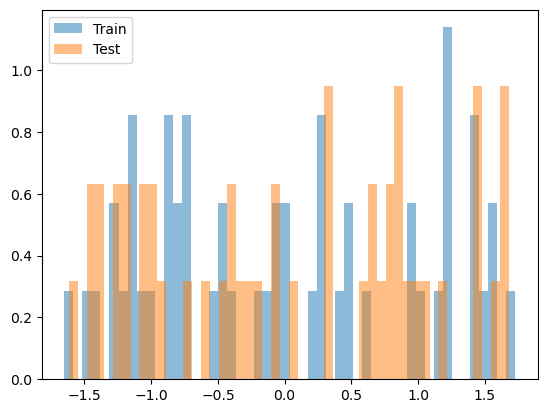

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(0.26482250083989317,
 array([0.5, 0. , 1. , 0.5, 1. , 1. , 0. , 0. , 0. , 1. , 1. , 1. , 0. ,
        0.5, 0. , 1. , 0.5, 0.5, 0. , 0. ]),
 array([[ 1.78634147,  1.9360867 ,  1.88877202, -1.3236466 , -0.79848959,
         -1.07663098,  0.75693198,  1.47072531, -0.64210535,  0.70222238,
         -0.25650619,  1.47441563, -1.53368866, -1.3861355 ,  1.21150587,
          0.78644392,  1.94941579,  1.0448482 ,  1.47620847, -0.25594202,
         -1.0173347 ,  1.53229239, -0.89926025,  0.61172586,  1.2217525 ,
         -1.55385798,  1.37288448, -0.72504126, -0.89490659,  1.53101721,
         -0.99542111, -0.6372661 , -1.23360731, -0.87627214,  0.76527065,
          0.8175526 , -0.49720711,  1.30480752, -1.26397969,  1.07416109,
          1.08311574, -0.08400376, -0.68275791, -0.23424647,  0.87116714,
         -0.3445116 ,  0.73235506,  0.68812829, -1.39046323,  0.22882867]]))